In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity

In [60]:
image = cv2.imread('sar_1_gray.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

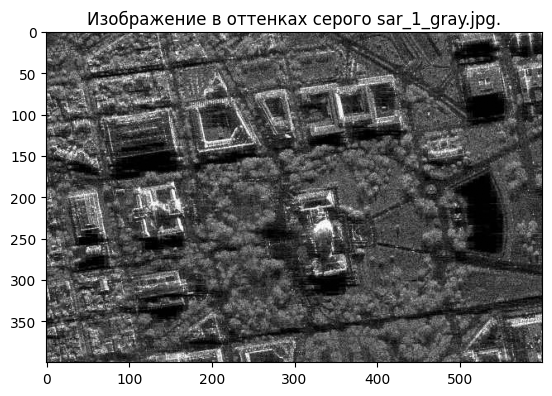

In [71]:
plt.title('Изображение в оттенках серого sar_1_gray.jpg.')
plt.imshow(image_gray, cmap='gray')

In [51]:
histSize = 256
histRange = (0, 256)
accumulate = False

b_hist = cv2.calcHist([image_gray], [0], None, [histSize], histRange, accumulate=accumulate)

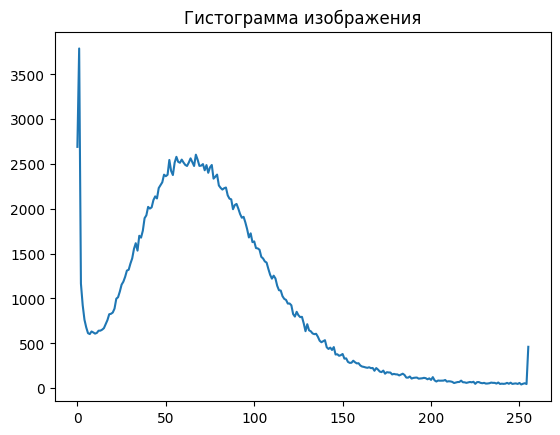

In [55]:
plt.title('Гистограмма изображения')
plt.plot(b_hist)

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

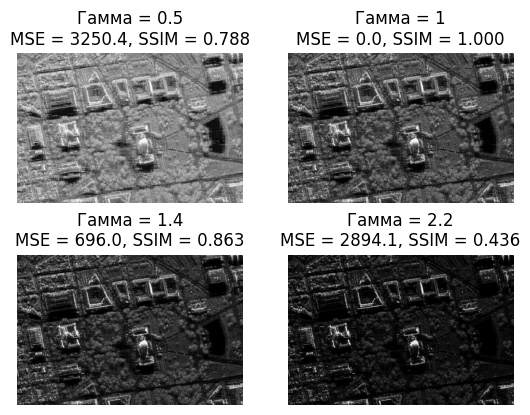

In [97]:
def gamma_correction(image, gamma):
    image_normalized = image.astype(np.float32) / 255.0
    corrected = np.power(image_normalized, gamma)
    return (corrected * 255).astype(np.uint8)

def calculate_metrics(original, corrected):
    mse = mean_squared_error(original, corrected)
    ssim = structural_similarity(original, corrected)
    return mse, ssim

gamma_05 = gamma_correction(image_gray, 0.5)  
gamma_14 = gamma_correction(image_gray, 1.4)  
gamma_22 = gamma_correction(image_gray, 2.2)  

mse_05, ssim_05 = calculate_metrics(image_gray, gamma_05)
mse_14, ssim_14 = calculate_metrics(image_gray, gamma_14)
mse_22, ssim_22 = calculate_metrics(image_gray, gamma_22)
mse, ssim = calculate_metrics(image_gray, image_gray)

plt.subplot(2, 2, 2)
plt.imshow(image_gray, cmap='gray')
plt.title(f'Гамма = 1\nMSE = {mse:.1f}, SSIM = {ssim:.3f}')
plt.axis('off')

plt.subplot(2, 2, 1)
plt.imshow(gamma_05, cmap='gray')
plt.title(f'Гамма = 0.5\nMSE = {mse_05:.1f}, SSIM = {ssim_05:.3f}')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(gamma_14, cmap='gray')
plt.title(f'Гамма = 1.4\nMSE = {mse_14:.1f}, SSIM = {ssim_14:.3f}')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(gamma_22, cmap='gray')
plt.title(f'Гамма = 2.2\nMSE = {mse_22:.1f}, SSIM = {ssim_22:.3f}')
plt.axis('off')


Text(0.5, 1.0, 'Статистическая коррекция\nMSE: 2946.7, SSIM: 0.786')

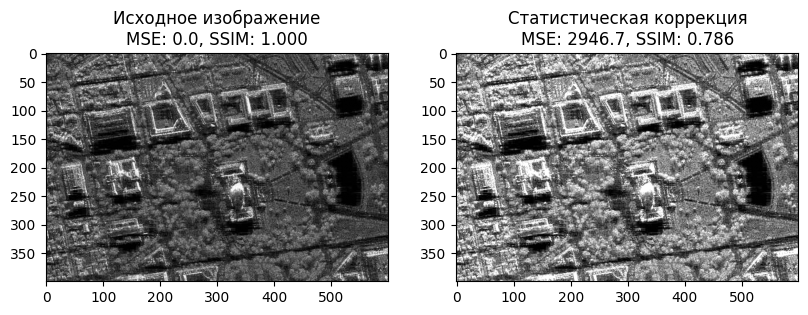

In [108]:
def statistical_color_correction_correct(image):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()
    eq_gray = cv2.equalizeHist(gray_image)
    mean_src = gray_image.mean()
    std_src = gray_image.std()
    mean_ref = eq_gray.mean()
    std_ref = eq_gray.std()
    if len(image.shape) == 3:
        b, g, r = cv2.split(image.astype(np.float32))
        for channel in [b, g, r]:
            channel_mean = channel.mean()
            channel_std = channel.std()
            if channel_std > 0:
                channel[:] = (channel - channel_mean) * (std_ref / std_src) + mean_ref
        b = np.clip(b, 0, 255).astype(np.uint8)
        g = np.clip(g, 0, 255).astype(np.uint8)
        r = np.clip(r, 0, 255).astype(np.uint8)
        corrected_image = cv2.merge((b, g, r))
    else:
        if std_src > 0:
            corrected_image = (gray_image.astype(np.float32) - mean_src) * (std_ref / std_src) + mean_ref
            corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
        else:
            corrected_image = gray_image.copy()
    return corrected_image

corrected_stat = statistical_color_correction_correct(image_gray)
mse_stat, ssim_stat = calculate_metrics(image_gray, corrected_stat)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap='gray')
plt.title(f'Исходное изображение\nMSE: {mse:.1f}, SSIM: {ssim:.3f}')

plt.subplot(1, 3, 2)
plt.imshow(corrected_stat, cmap='gray')
plt.title(f'Статистическая коррекция\nMSE: {mse_stat:.1f}, SSIM: {ssim_stat:.3f}')

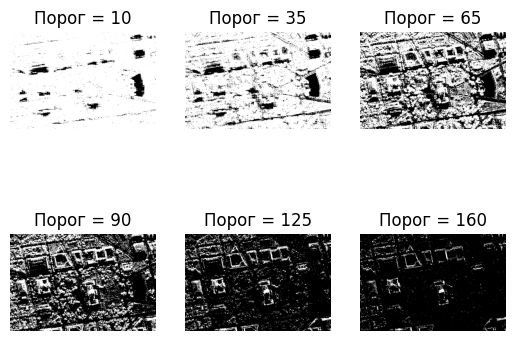

In [104]:
thresholds = [10, 35, 65, 90, 125, 160]
for i, threshold in enumerate(thresholds, 1):
    _, thresh = cv2.threshold(image_gray, threshold, 255, cv2.THRESH_BINARY)
    plt.subplot(2, 3, i)
    plt.imshow(thresh, cmap='gray')
    plt.title(f'Порог = {threshold}')
    plt.axis('off')